In [1]:
import os
import time

import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128
                                                    , shuffle=True, num_workers=16)

test_loader = torch.utils.data.DataLoader(testset,batch_size=128
                                                     , shuffle=True, num_workers=16)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
all_train_labels = []
all_test_labels = []
all_val_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)



print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))




Training labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Training label distribution: tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

Test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Test label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


In [4]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate) :
        super(_DenseLayer,self).__init__()
        self.denselayers = nn.Sequential(
            OrderedDict(
                [   ("norm1", nn.BatchNorm2d(num_input_features)),
                    ("ELU1", nn.ELU(inplace=True)),
                    ("conv1", nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
                    ("norm2", nn.BatchNorm2d(bn_size * growth_rate)),
                    ("ELU2", nn.ELU(inplace=True)),
                    ("conv2", nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
                ]
            )
        )
        self.drop_rate=drop_rate


    def forward(self, input):
        concated_features = torch.cat(input, 1)
        new_features = self.denselayers(concated_features)
        new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features



class _DenseBlock(nn.ModuleDict):

    def __init__(self,num_layers,num_input_features,bn_size,growth_rate,drop_rate):
        super(_DenseBlock,self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition,self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.ELU = nn.ELU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNetIOC(nn.Module):

    def __init__(self,growth_rate= 32,block_config=[6, 12, 24, 16],num_init_features= 64,bn_size= 4,drop_rate = 0,num_classes = 1000):

        super(DenseNetIOC,self).__init__()

        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("ELU0", nn.ELU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        self.classifier = nn.Linear(num_features, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.elu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out




In [5]:
def train_model_ioc(optimizer,scheduler,trainloader,testloader,criterion,model,epochs,epsilon):
    
    def train(optimizer,trainloader,criterion):
        model.train()
        train_loss=0
        y_true=[]
        y_pred=[]
        for images, labels in trainloader:
            model.zero_grad() 
            data = images.to(device)
            target = labels.to(device)
            output = model(data)
            loss = criterion(output,target)
            indices=torch.max(output,1)[1] 
            train_loss+=loss.item()
            y_true+=list(target.detach().cpu().numpy())
            y_pred+=list(indices.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
              i=0
              for params in model.parameters():
                  if i != 0:
                    newparams=params.detach().clone()
                    params.copy_(torch.where(newparams < 0, torch.exp(newparams - epsilon), newparams))
                  i=i+1
        
        return train_loss/len(trainloader),accuracy_score(y_true,y_pred)
    def test(testloader,criterion):
        model.eval()
        y_true=[]
        y_pred=[]        
        val_loss = 0
        with torch.no_grad():
          for images, labels in testloader:
              data = images.to(device)
              target = labels.to(device)
              output = model(data)
              indices=torch.max(output,1)[1]
              y_true+=list(target.detach().cpu().numpy())
              y_pred+=list(indices.detach().cpu().numpy())
              val_loss += criterion(output, target).item()
        return val_loss/len(testloader),accuracy_score(y_true,y_pred)

        
    train_loss=[]

    test_loss=[]
    train_acc=[]

    test_acc=[]
    for epoch in tqdm(range(1, epochs + 1)):
        
        tr_loss,tr_acc=train(optimizer=optimizer,trainloader=trainloader,criterion=criterion)
        ts_loss,ts_acc=test(testloader,criterion=criterion)
        scheduler.step()
        train_loss.append(tr_loss)
        test_loss.append(ts_loss)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
        print("\n",tr_acc)
        print(ts_acc)
    return (train_loss,test_loss),(train_acc,test_acc)
    
def plot(Loss,EPOCH):
  x = list(range(1,EPOCH+1))
  fig, ax = plt.subplots(figsize=(7,7))
  ax.plot(x, Loss[0], '-', label='train', color='green')
  ax.plot(x, Loss[1], '-', label='test', color='red')

  ax.legend()
  plt.show()

  2%|▏         | 1/50 [00:54<44:41, 54.72s/it]


 0.17378
0.1716


  4%|▍         | 2/50 [01:50<44:16, 55.34s/it]


 0.21372
0.227


  6%|▌         | 3/50 [02:46<43:31, 55.56s/it]


 0.23136
0.2387


  8%|▊         | 4/50 [03:42<42:50, 55.88s/it]


 0.25352
0.2735


 10%|█         | 5/50 [04:38<41:45, 55.68s/it]


 0.29092
0.3


 12%|█▏        | 6/50 [05:33<40:50, 55.68s/it]


 0.30346
0.2841


 14%|█▍        | 7/50 [06:29<39:51, 55.61s/it]


 0.3229
0.3192


 16%|█▌        | 8/50 [07:24<38:51, 55.52s/it]


 0.35164
0.3532


 18%|█▊        | 9/50 [08:20<37:59, 55.59s/it]


 0.38308
0.3715


 20%|██        | 10/50 [09:15<37:03, 55.58s/it]


 0.40044
0.4156


 22%|██▏       | 11/50 [10:11<36:10, 55.65s/it]


 0.42154
0.435


 24%|██▍       | 12/50 [11:05<34:52, 55.08s/it]


 0.4334
0.408


 26%|██▌       | 13/50 [11:58<33:38, 54.55s/it]


 0.43904
0.4137


 28%|██▊       | 14/50 [12:52<32:32, 54.22s/it]


 0.44564
0.4099


 30%|███       | 15/50 [13:45<31:31, 54.05s/it]


 0.45142
0.43


 32%|███▏      | 16/50 [14:39<30:29, 53.81s/it]


 0.45978
0.4686


 34%|███▍      | 17/50 [15:32<29:28, 53.58s/it]


 0.46284
0.4662


 36%|███▌      | 18/50 [16:24<28:24, 53.28s/it]


 0.4691
0.4186


 38%|███▊      | 19/50 [17:18<27:39, 53.53s/it]


 0.47446
0.433


 40%|████      | 20/50 [18:12<26:44, 53.48s/it]


 0.47686
0.4409


 42%|████▏     | 21/50 [19:05<25:51, 53.51s/it]


 0.48904
0.4966


 44%|████▍     | 22/50 [19:58<24:53, 53.33s/it]


 0.48988
0.4967


 46%|████▌     | 23/50 [20:51<23:57, 53.25s/it]


 0.49228
0.4951


 48%|████▊     | 24/50 [21:44<23:03, 53.20s/it]


 0.49086
0.4941


 50%|█████     | 25/50 [22:37<22:08, 53.12s/it]


 0.49148
0.4942


 52%|█████▏    | 26/50 [23:29<21:08, 52.86s/it]


 0.49372
0.4984


 54%|█████▍    | 27/50 [24:23<20:22, 53.15s/it]


 0.49478
0.4969


 56%|█████▌    | 28/50 [25:16<19:25, 53.00s/it]


 0.49248
0.4998


 58%|█████▊    | 29/50 [26:09<18:31, 52.92s/it]


 0.49454
0.4952


 60%|██████    | 30/50 [27:01<17:35, 52.76s/it]


 0.49366
0.4978


 62%|██████▏   | 31/50 [27:54<16:42, 52.75s/it]


 0.4946
0.485


 64%|██████▍   | 32/50 [28:47<15:51, 52.85s/it]


 0.49436
0.499


 66%|██████▌   | 33/50 [29:41<15:02, 53.08s/it]


 0.49516
0.5019


 68%|██████▊   | 34/50 [30:33<14:06, 52.93s/it]


 0.49548
0.4941


 70%|███████   | 35/50 [31:26<13:13, 52.91s/it]


 0.49654
0.5036


 72%|███████▏  | 36/50 [32:19<12:20, 52.92s/it]


 0.49748
0.4997


 74%|███████▍  | 37/50 [33:11<11:26, 52.78s/it]


 0.49562
0.4977


 76%|███████▌  | 38/50 [34:04<10:33, 52.82s/it]


 0.49782
0.5031


 78%|███████▊  | 39/50 [34:57<09:41, 52.89s/it]


 0.49948
0.5023


 80%|████████  | 40/50 [35:51<08:50, 53.01s/it]


 0.49848
0.5019


 82%|████████▏ | 41/50 [36:43<07:56, 52.96s/it]


 0.50096
0.5059


 84%|████████▍ | 42/50 [37:36<07:01, 52.73s/it]


 0.5026
0.5048


 86%|████████▌ | 43/50 [38:28<06:07, 52.55s/it]


 0.50096
0.5082


 88%|████████▊ | 44/50 [39:20<05:15, 52.56s/it]


 0.50132
0.5089


 90%|█████████ | 45/50 [40:13<04:22, 52.59s/it]


 0.50248
0.5051


 92%|█████████▏| 46/50 [41:06<03:30, 52.68s/it]


 0.49942
0.5073


 94%|█████████▍| 47/50 [41:59<02:38, 52.91s/it]


 0.5015
0.5087


 96%|█████████▌| 48/50 [42:52<01:45, 52.88s/it]


 0.50062
0.5063


 98%|█████████▊| 49/50 [43:45<00:52, 52.89s/it]


 0.50076
0.5081


100%|██████████| 50/50 [44:38<00:00, 53.58s/it]


 0.50072
0.5065


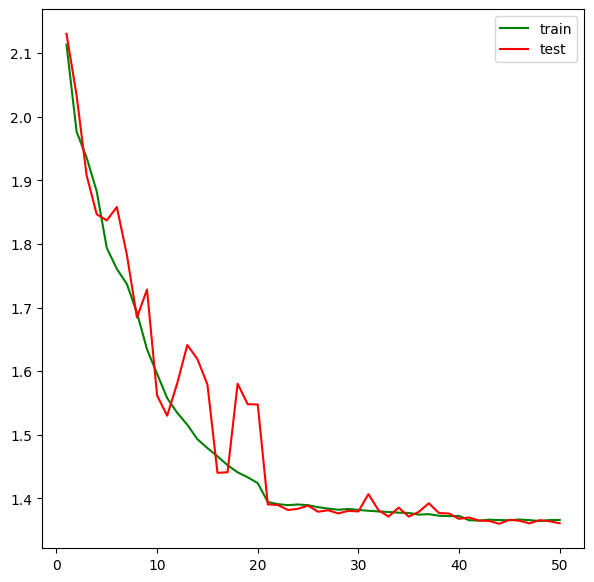

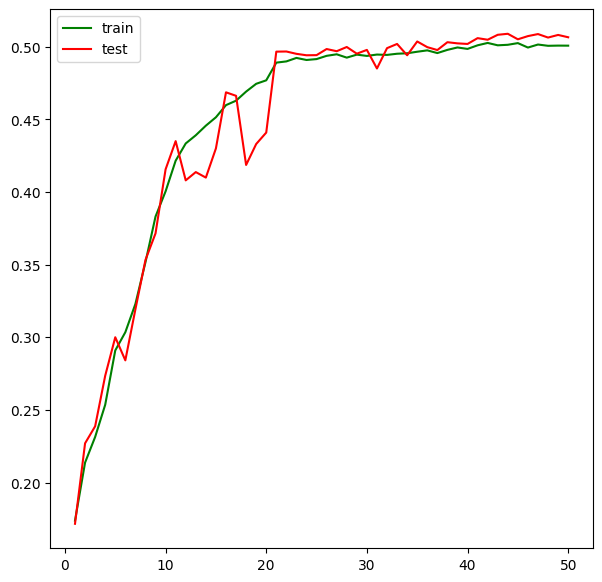

In [9]:
dense_net=DenseNetIOC(block_config=[6,12,24,16],growth_rate=12,num_classes=len(torch.unique(all_train_labels)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH=50
epsilon=5
criterion =  nn.CrossEntropyLoss()
dense_net = dense_net.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(dense_net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
Loss,accuracy=train_model_ioc(optimizer,scheduler,train_loader,test_loader,criterion,dense_net,EPOCH,epsilon)
plot(Loss,EPOCH)
plot(accuracy,EPOCH)